In [11]:
%matplotlib inline
from matplotlib.colors import LogNorm
from nansat import *

In [12]:
# Open source data:
# Access OC CCI data online usine OpenDAP protocol
n_occci = Nansat('occci_online:8D:Rrs_412:2010-08-05', lons=[-35, -60], lats=[-6, 15])
# Access local SMOS data downloaded from http://cp34-bec.cmima.csic.es/
n_smos = Nansat('BEC_OI_____B_20100811T003802_20100820T004052_2013001_025_001.nc')
# Access local TOPAZ data
n_topaz = Nansat('TP4DAILY_2010_222.nc')

10:40:59|40|nansat|_get_mapper|GDAL could not open occci_online:8D:Rrs_412:2010-08-05, trying to read with Nansat mappers...
ERROR:Nansat:GDAL could not open occci_online:8D:Rrs_412:2010-08-05, trying to read with Nansat mappers...


Get lon, lat, time
Get  8D Rrs_412
from  ./CCI_ALL-v2.0-8DAY_8D_Rrs_412_20100805_-059-035-005+014.tif ...
from  ./CCI_ALL-v2.0-8DAY_8D_Rrs_412_20100805_-059-035-005+014.tif
=>Sea Surface Salinity L3 OI map<=
=>tecconv generated fields<=


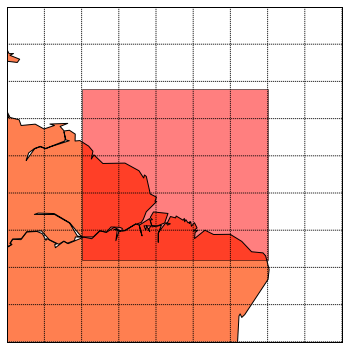

In [13]:
# Define region of interest near Amazon esturay
dstDomain = Domain(NSR().wkt, '-te -60 -6 -35 15 -tr 0.1 0.1')
dstDomain.write_map('aa.png', pltshow=True)
lon, lat = dstDomain.get_geolocation_grids()

# Collocate datasets on the same grid
n_occci.reproject(dstDomain)
n_smos.reproject(dstDomain)
n_topaz.reproject(dstDomain)

In [14]:
# Fetch equal-size arrays of data

# Fetch reflectance at 412 nm from OC CCI
Rrs_412 = n_occci['Rrs_412']

# Fetch sea surface salinity from SMOS-BEC
sss = n_smos['SSS']

# Fetch eastward and northward components of surface current from TOPAZ
u = n_topaz['utot01']
v = n_topaz['vtot01']

In [15]:
# Use numpy to establish 2nd order polynomial
# which relates SSS and Rrs_412

# create mask of pixels valid for analysis
mask = np.isfinite(sss) * np.isfinite(Rrs_412) * (sss > 32) * (sss < 36)
# create polynomial from valid pixels
p = np.polyfit(Rrs_412[mask], sss[mask], 2)

# apply polynomial on reflectance data
sss_modis = np.zeros_like(sss) + np.nan
sss_modis[mask] = np.polyval(p, Rrs_412[mask])

/home/antonk/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in greater
/home/antonk/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in less


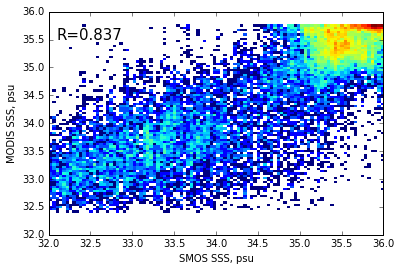

In [16]:
# create plot (2d histogram) which compares SSS from SMOS and from MODIS
hst = plt.hist2d(sss[mask], sss_modis[mask], 100, [[32, 36], [32, 36]], norm=LogNorm())
plt.xlabel('SMOS SSS, psu')
plt.ylabel('MODIS SSS, psu')
plt.text(32.1, 35.5, 'R=%5.3f' % np.corrcoef([sss[mask], sss_modis[mask]])[0,1], size=15)
plt.savefig('hist2d_sss.eps', dpi=300, pad_inches=0, bbox_inches='tight')

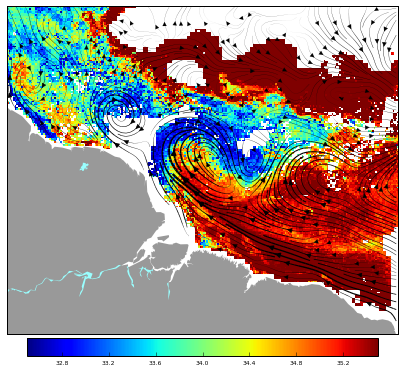

In [20]:
# Create map comparing SSS from MODIS and surface currents from TOPAZ

# create map canvas
nmap = Nansatmap(dstDomain, resolution='l', figsize=(7,7))
# show MODIS SSS distribution
nmap.imshow(sss_modis, vmin=32.5, vmax=35.5, interpolation='nearest')
# plot streamlines of surface current
nmap.streamplot(lon, lat, u, v, 3, linewidth=np.hypot(u, v), color='k')
# add colorbar and save the plot
nmap.add_colorbar(shrink=0.9)
nmap.save('amazon_sss_streams.png', dpi=300)

In [8]:
plt.savefig?